In [15]:
%config Completer.use_jedi = False

from utils import *
from parallel import find_sigma_em
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import curve_fit

import importlib
from tqdm.notebook import tqdm

In [3]:
TTc = 2/np.log(1+np.sqrt(2))

In [27]:
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = [6,4]
prop_cycle = plt.rcParams['axes.prop_cycle']
COLORS = prop_cycle.by_key()['color']
import style 

# Relaxation times

In [3]:
with open("dumps/relaxations.pkl","rb") as f:
    results = pickle.load(f)

df = pd.DataFrame(results, columns=["T",  "RTM_const", "RTE_const", "RTM_rand", "RTE_rand"])

gb = df.groupby("T")

dfmoments = pd.concat([
gb.mean().add_suffix("_mean"),
gb.std().add_suffix("_std")], axis=1)
dfm = dfmoments[sorted(dfmoments.columns)]

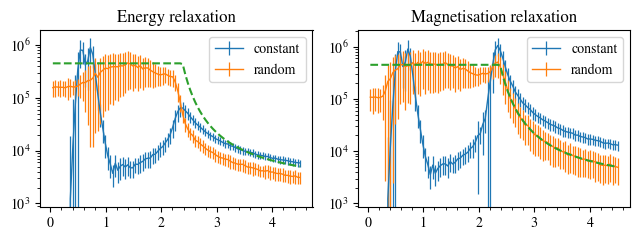

In [45]:
sprs = 2
kws = dict(lw=1, elinewidth=0.9)
plt.figure(figsize=(6.5,2.5))
plt.subplot(121)
plt.title("Energy relaxation")
plt.errorbar(dfm.index, dfm.RTE_const_mean, yerr=dfm.RTE_const_std/sprs, label="constant", **kws)
plt.errorbar(dfm.index, dfm.RTE_rand_mean, yerr=dfm.RTE_rand_std/sprs, label="random", **kws)
plt.plot(dfm.index, [relaxation_time_normalized(x)*32*32 for x in dfm.index], "--", zorder=100)
plt.gca().set_yscale("log")
plt.minorticks_on()
plt.legend()


plt.subplot(122)
plt.title("Magnetisation relaxation")
plt.errorbar(dfm.index, dfm.RTM_const_mean, yerr=dfm.RTM_const_std/sprs, label="constant", **kws)
plt.errorbar(dfm.index, dfm.RTM_rand_mean, yerr=dfm.RTM_rand_std/sprs, label="random", **kws)
plt.gca().set_yscale("log")
plt.plot(dfm.index, [relaxation_time_normalized(x)*32*32 for x in dfm.index], "--", zorder=100)
plt.minorticks_on()

plt.legend()

plt.tight_layout()
plt.savefig("figs/relaxation.pdf")

# Time autocorrelation function of magnetization

In [13]:
T, M = {}, {}
for N in [4,10,32,64]:
    with open(f"dumps/autocor-{N}-9.pkl","rb") as f:
        _T, _M = pickle.load(f)
        T[N] = np.array(_T)
        M[N] = np.array(_M)

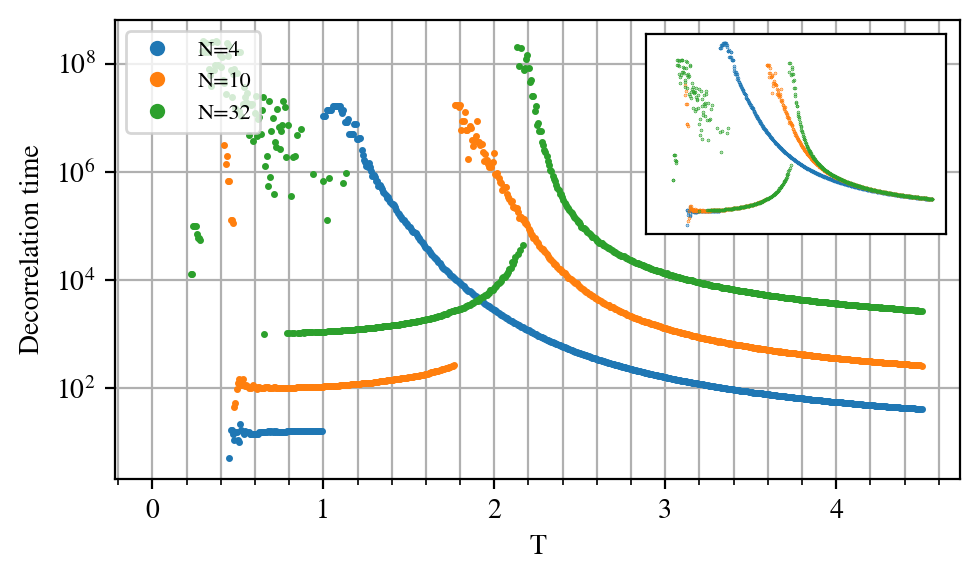

In [15]:

kws = dict(lw=1, elinewidth=0.9)
fig= plt.figure(figsize=(5,3), dpi=200)
ax = plt.gca()
# ax = pl

plt.minorticks_on()
plt.grid(which="both", axis="x")
plt.grid(which="major", axis="y")
for N in [4,10,32]:
    plt.plot(T[N], M[N], ".", ms=3,label=f"N={N}")
#     plt.plot(T[N], [relaxation_time_normalized(x)*N*N for x in T[N]], "--")
ax.set_yscale("log")
plt.legend(loc="upper left", markerscale=3, fontsize=8)
plt.xlabel("T")
plt.ylabel("Decorrelation time")
plt.tight_layout()

axins = inset_axes(ax, width=1.5, height=1)
for N in [4,10,32]:
    plt.plot(T[N], M[N]/N**2, ".", ms=0.5,label=f"N={N}")
axins.set_yscale("log")
axins.tick_params(tick1On=False,labelleft=False, labelbottom=False)
plt.savefig("figs/autocorr.pdf")

In [93]:
T[4][0:][np.argmax(M[4][0:])]

1.0546875

In [95]:
T[10][0:][np.argmax(M[10][0:])]

1.7859375

In [88]:
T[32][200:][np.argmax(M[32][200:])]

2.13046875

# Mean Magnetisation

In [136]:
with open("dumps/32x32-rangeMT-const-1e7steps-withH.pkl","rb") as f:
    results_p, results_n = pickle.load(f)
Ts_p = np.array([T for T, _, M, _, E, _ in results_p])
meanMs_n = np.array([M[-2] for T, _, M, _, E, _ in results_n])
meanMs_p = np.array([M[-2] for T, _, M, _, E, _ in results_p])

perm = np.random.permutation(2*len(Ts_p))
Ts_tot = np.concatenate([Ts_p,Ts_p])[perm]
Ms_tot = np.concatenate([meanMs_p, -meanMs_n])[perm]
c_tot = np.concatenate([np.zeros_like(Ts), np.ones_like(Ts)])[perm]


with open("dumps/32x32-rangeMT-rand-1e7steps.pkl","rb") as f:
    results = pickle.load(f)
with open("dumps/32x32-rangeMT-rand-1e7steps-v2.pkl","rb") as f:
    results += pickle.load(f)

Ts = np.array([T for T, _, M, _, E, _ in results])
meanMs = np.array([M[-3] for T, _, M, _, E, _ in results])

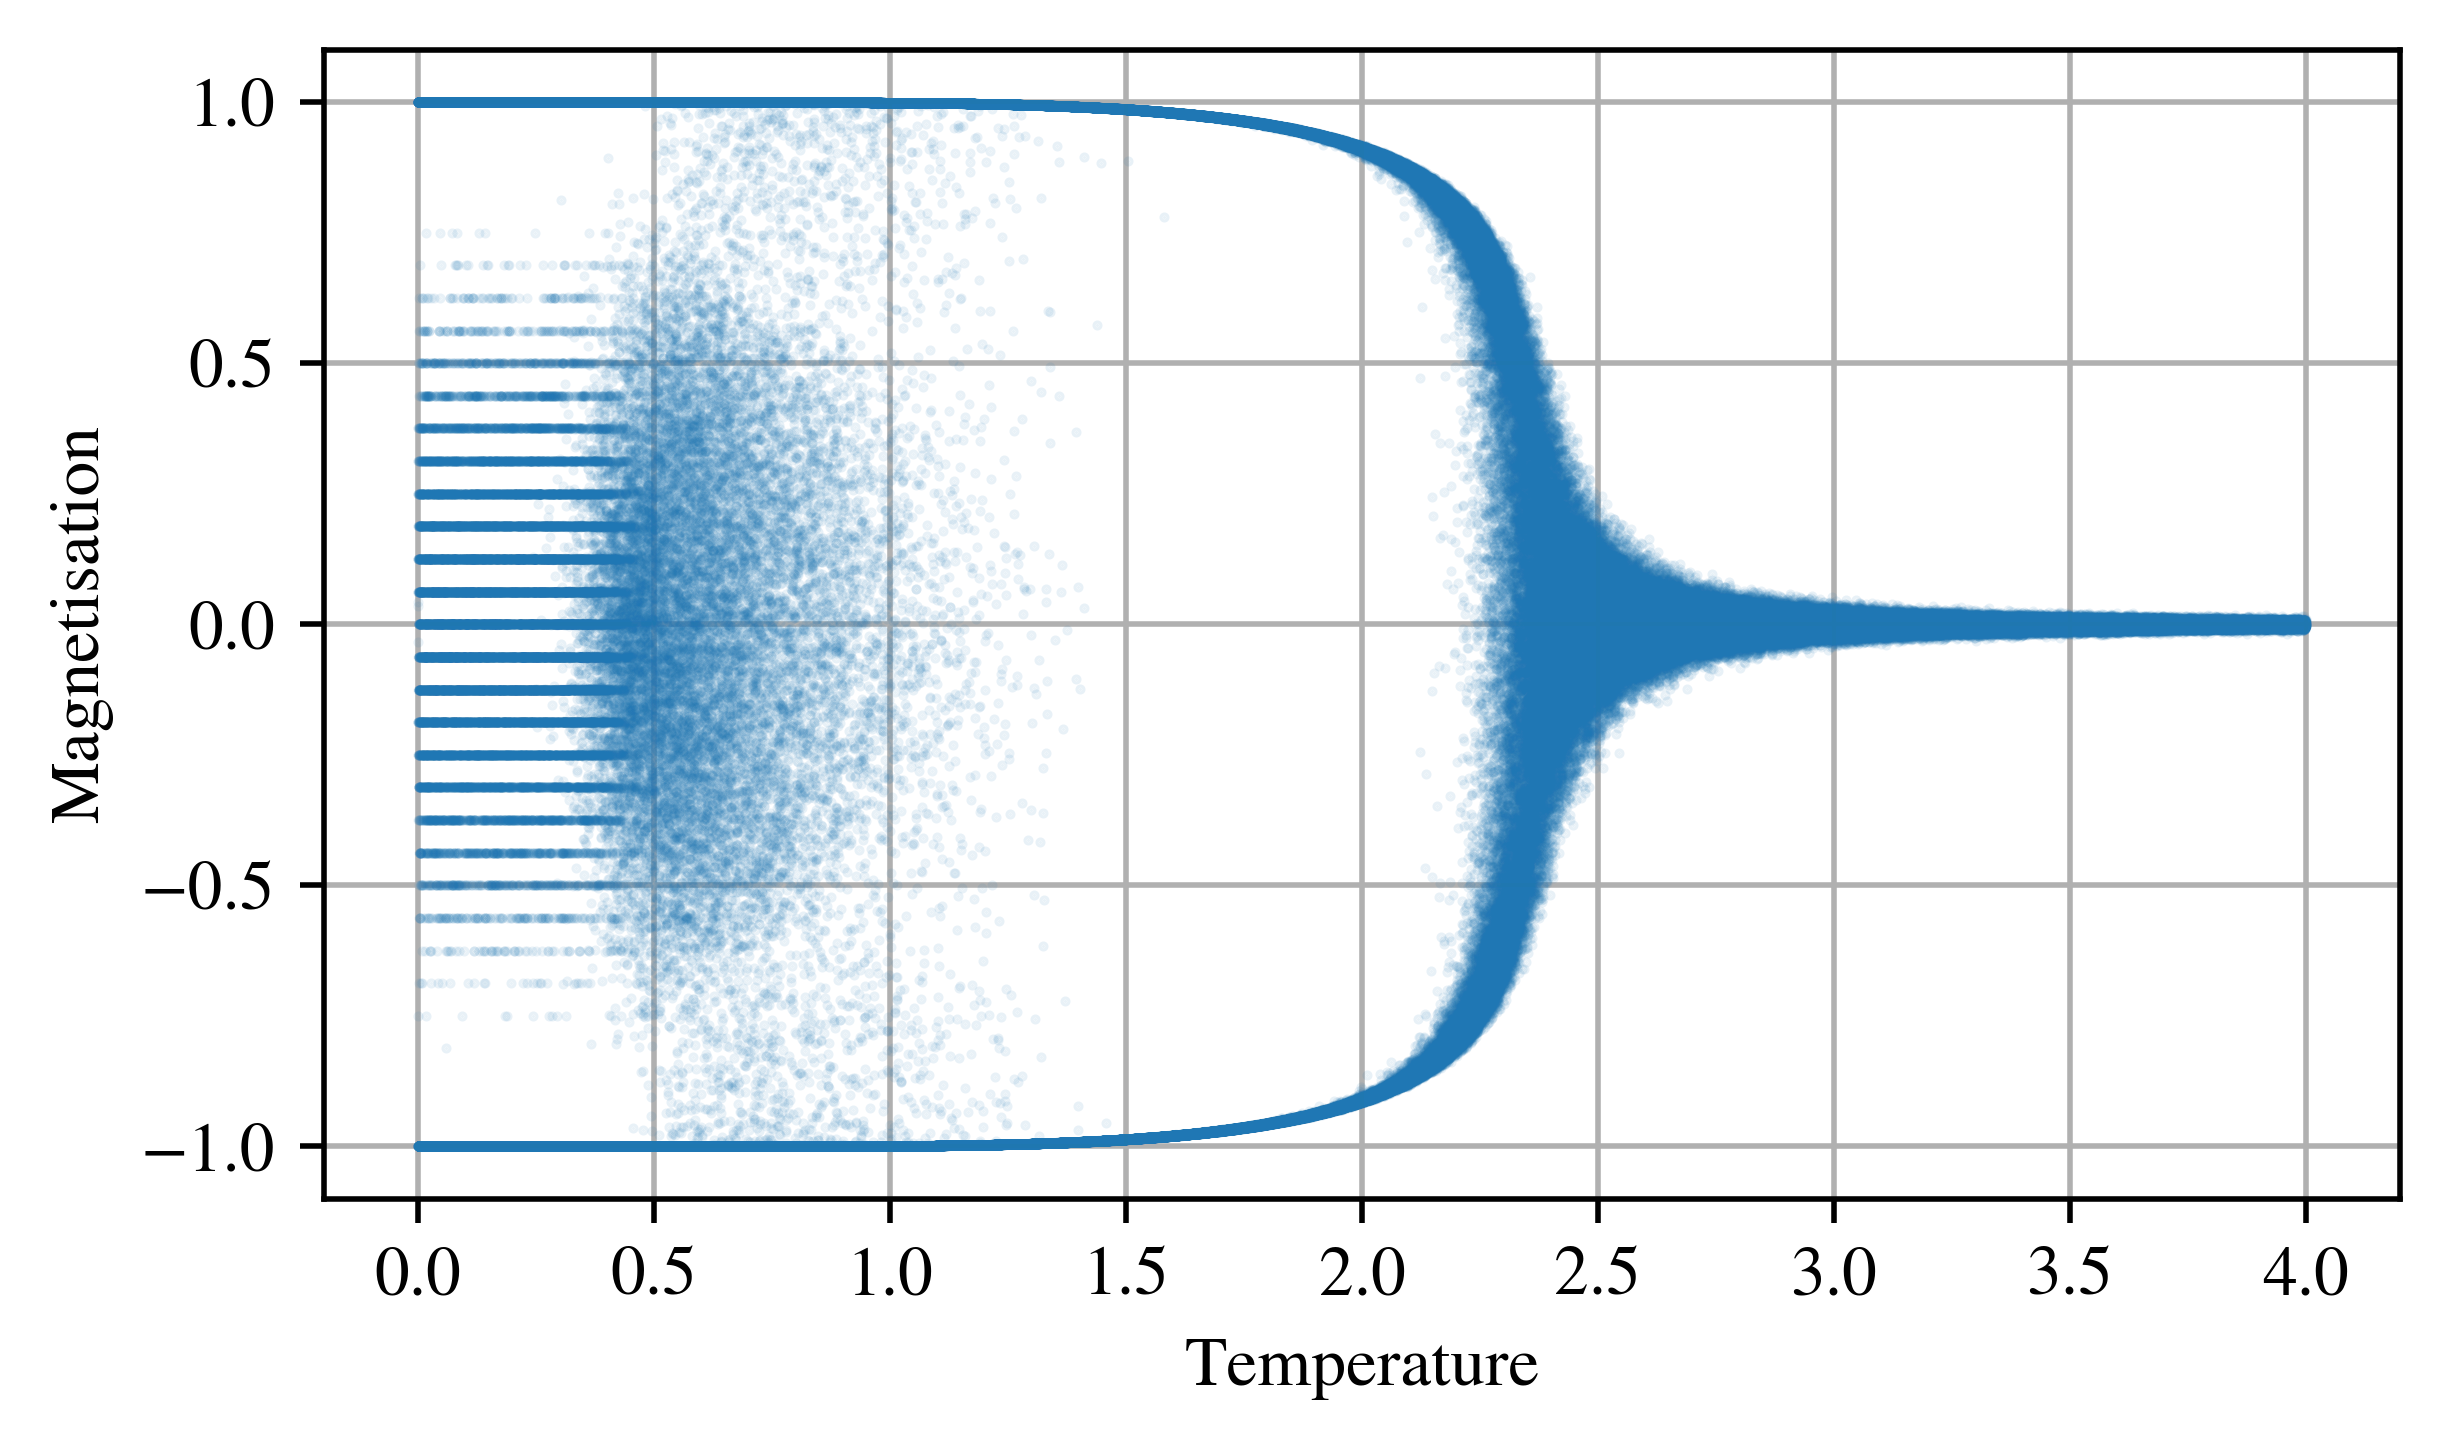

In [158]:
fig = plt.figure(figsize=(5,3), dpi=500)
# cmap = cm.get_cmap("jet")
# c = cmap((1-Ts/4)*0.5)
plt.grid(zorder=-100)
plt.scatter(Ts, meanMs/1024, s=0.2, c=COLORS[0], alpha=0.1, rasterized=True, zorder=4)
ax = plt.gca()
ax.set_ylabel('Magnetisation')
ax.set_xlabel('Temperature')
plt.tight_layout()
plt.savefig("figs/magnetisation2d.pdf")
plt.show()

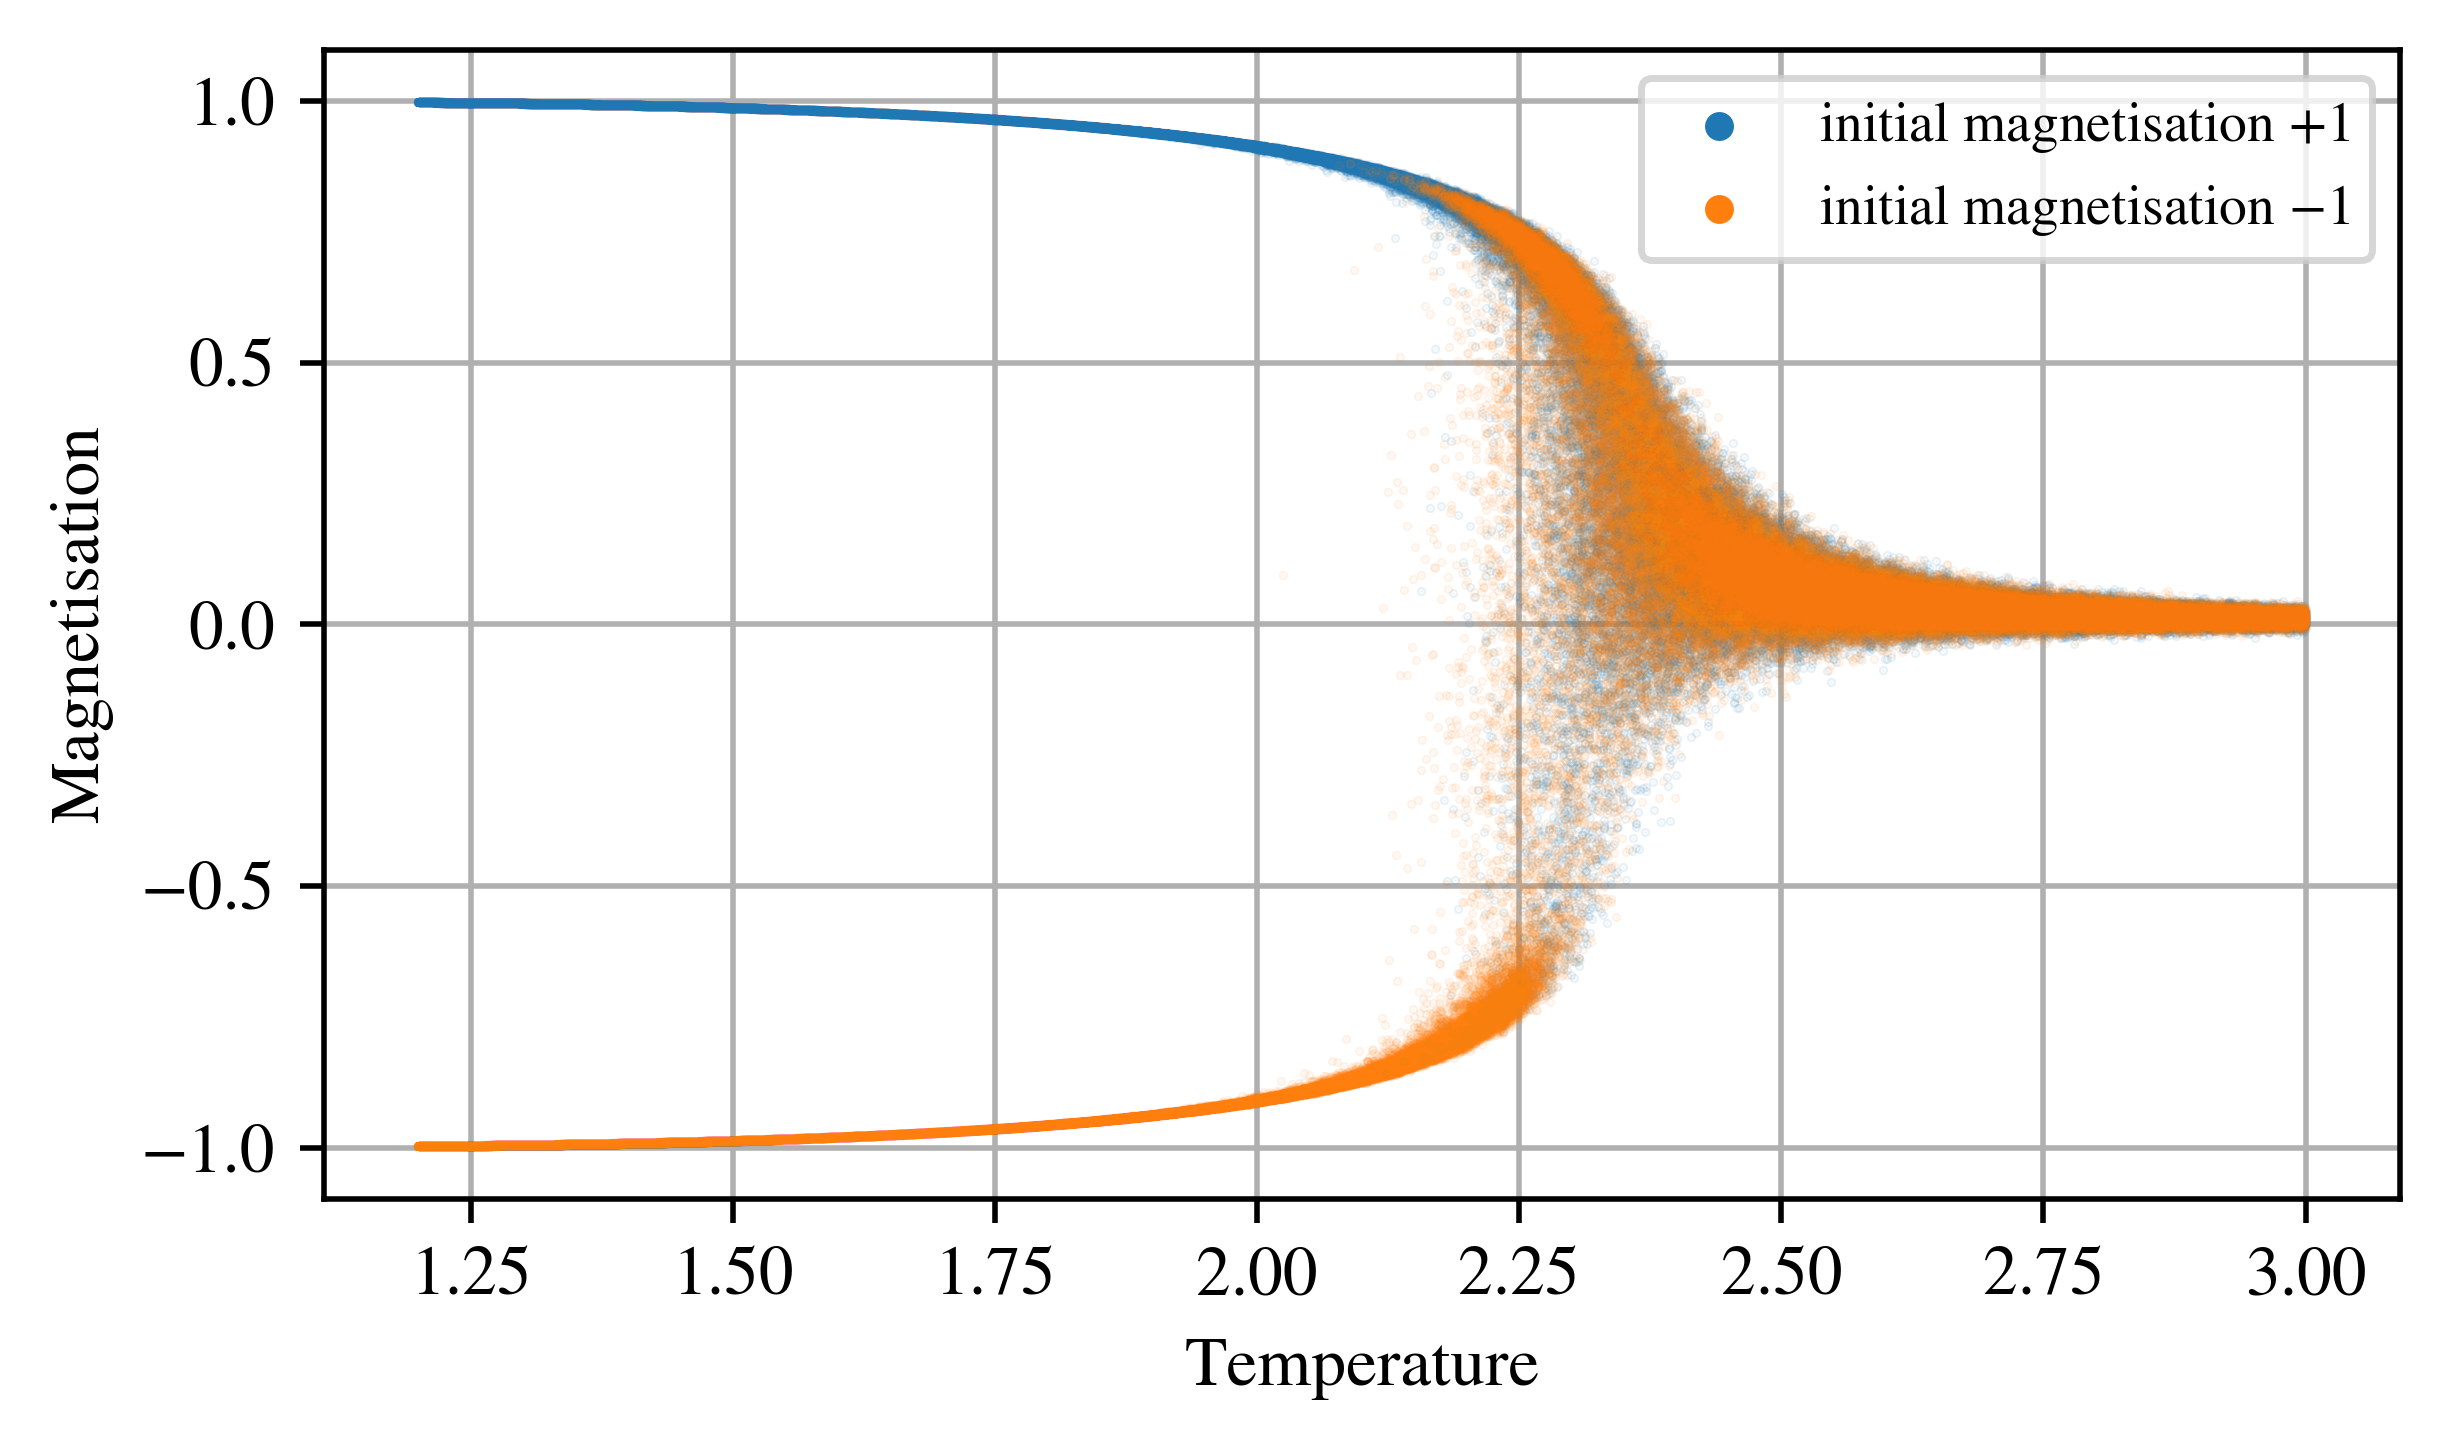

In [159]:
fig = plt.figure(figsize=(5,3), dpi=500)
# cmap = cm.get_cmap("jet")
# c = cmap((1-Ts/4)*0.5)
plt.grid(zorder=-100)
# plt.scatter(Ts_tot, Ms_tot/1024, marker="o", s=1,c=c_tot, alpha=0.1, rasterized=True, zorder=4, cmap="coolwarm")
plt.scatter(Ts_p, meanMs_p/1024, s=0.1, c=COLORS[0], alpha=0.1, rasterized=True, zorder=4, label="initial magnetisation $+1$")
plt.scatter(Ts_p, -meanMs_n/1024, s=0.1, c=COLORS[1], alpha=0.1, rasterized=True, zorder=4, label="initial magnetisation $-1$")

ax = plt.gca()
ax.set_ylabel('Magnetisation')
ax.set_xlabel('Temperature')
plt.tight_layout()
leg = plt.legend( markerscale=10, fontsize=8)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.savefig("figs/magnetisation2d-withH.pdf")
plt.show()

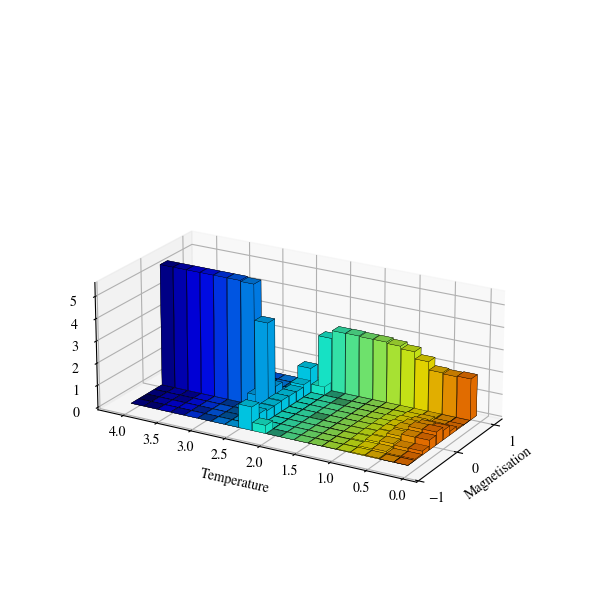

In [75]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

T1 = 0.5
dT = 0.1


fig = plt.figure(figsize=(6,6), dpi=100)
ax = fig.add_subplot(111, projection='3d')
nbins = 11
T1s = np.linspace(dT, 4-dT, 20)

cmap = cm.get_cmap("jet")
for i,(T1,) in enumerate(zip(T1s[::-1])):
    c = cmap((1-T1/4)*0.8)
    
    data = meanMs[(T1-dT < Ts) & (T1+dT > Ts)]
    hist, bins = np.histogram(data/1024, bins=nbins, range=(-1, 1), density=True)
    binpos = (bins[:-1] + bins[1:])/2
    keep = (binpos>-0.8)
    hist = hist[keep]
    binpos = binpos[keep]
#     ax.bar(binpos, hist, zs=T1, zdir='y', color=c, ec="k", alpha=0.8, width=(binpos[1]-binpos[0])*0.9)
#     ax.bar3d(x, y, bottom, width, depth, top, shade=True)
    ax.bar3d(binpos, T1, 0, (binpos[1]-binpos[0])*0.95, (T1s[1]-T1s[0])*0.95, hist, shade=True, 
             alpha=1, color=c, ec="k", linewidth=0.2)
    
ax.set_xticks([-1, 0,1] )
ax.set_xlabel('Magnetisation')
ax.set_ylabel('Temperature', labelpad=20)
ax.set_zlabel('')

x_scale=1
y_scale=2
z_scale=1

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0
def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj


ax.view_init(elev=20., azim=210)
plt.tight_layout()
# plt.savefig("figs/magnetisation3d.pdf")
plt.show()

# State

In [166]:
with open("dumps/states-N100.pkl", "rb") as f:
    results = pickle.load(f)
results = np.array(results, dtype=object)[[2,1,0,3,4,5,6]]

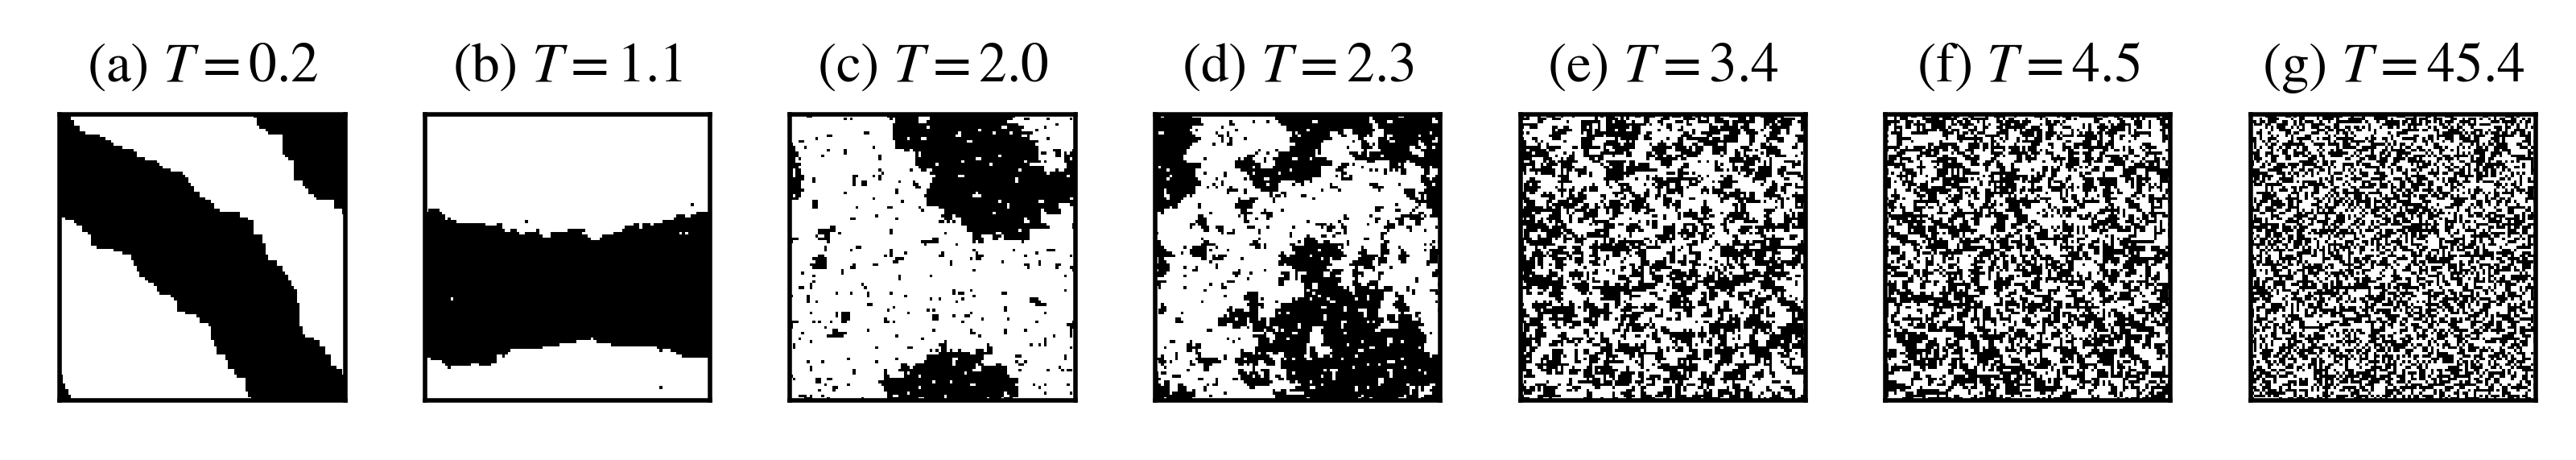

In [171]:
plt.figure(figsize=(6.5,1.1), dpi=500)
for i, (_, T, state) in enumerate(results):
    plt.subplot(1, len(results), i+1, )
    
    plt.title(f"({chr(ord('a')+i)}) $T={T:0.1f}$", fontdict=dict(size=10))
    if state.mean()<0:
        state = -state
    plt.imshow(state, cmap="gray", rasterized=True)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig("figs/states100.pdf")

# Heat Capacity

In [101]:
with open("dumps/HC-free.pkl","rb") as f:
    (Nf, Tf, Tf_err) = pickle.load(f)
with open("dumps/HC-periodic.pkl","rb") as f:
    (Np, Tp, Tp_err) = pickle.load(f)

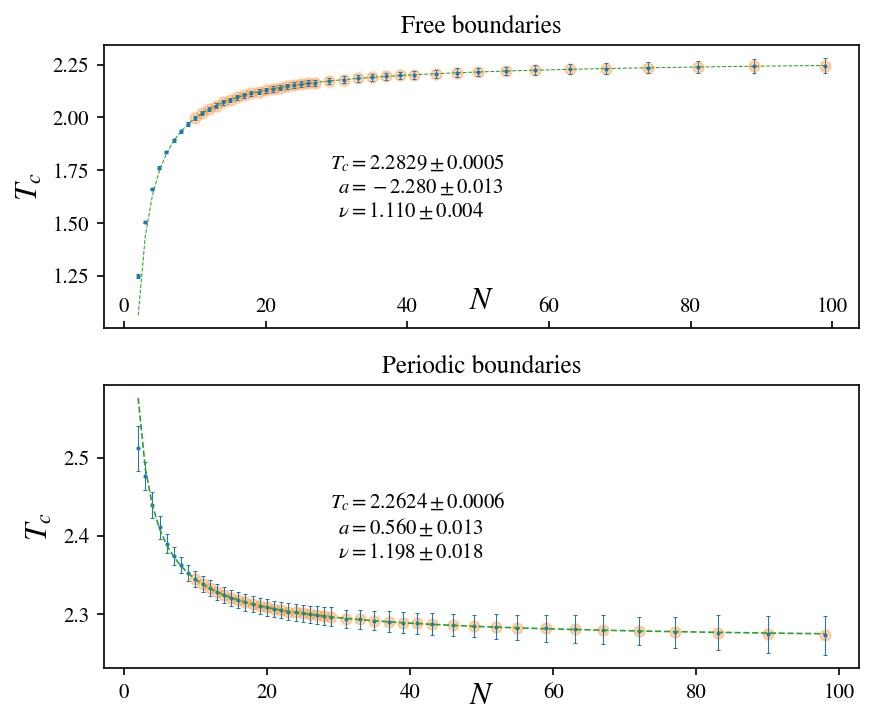

In [241]:
def f(x, Tc, a, nu):
    return Tc + a / (x ** (1/nu))

plt.figure(figsize=(6.5,5.5), dpi=150)
kws = dict(lw=1, elinewidth=0.5, capsize=1., capthick=0.5, fmt=".", ms=2)

nsigma = 50

plt.subplot(211)
with open("dumps/HC-free.pkl","rb") as file:
    (Ns, Ts, Ts_err) = pickle.load(file)
    
plt.title("Free boundaries")
plt.xlabel("$N$", fontdict={"size":15}, labelpad=-20)
plt.ylabel("$T_c$", fontdict={"size":15})
plt.gca().tick_params(axis="x",direction="in", pad=-15)

l,r= 8, 10000
popt, popt_cov = curve_fit(f, Ns[l:r], Ts[l:r], sigma=Ts_err[l:r])
Tc, a, mu = popt
Tc_err, a_err, mu_err = np.sqrt(popt_cov.diagonal())
# print(TTc)
plt.plot(Ns[l:r], Ts[l:r], ".",alpha=0.3, ms=10, c=COLORS[1])
plt.errorbar(Ns, Ts, yerr=Ts_err*nsigma, **kws, c=COLORS[0])

plt.plot(Ns, f(Ns, *popt), "--", lw=0.5, c=COLORS[2])

plt.text(0.3, 0.5, f'$T_c={Tc:0.4f}\pm{Tc_err:0.4f}$\n$\;\;a={a:0.3f}\pm{a_err:0.3f}$\n$\;\;\\nu={mu:0.3f}\pm{mu_err:0.3f}$', 
         horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes);

plt.subplot(212)
plt.title("Periodic boundaries")
plt.xlabel("$N$", fontdict={"size":15}, labelpad=-10)
plt.ylabel("$T_c$", fontdict={"size":15})

with open("dumps/HC-periodic.pkl","rb") as file:
    (Ns, Ts, Ts_err) = pickle.load(file)

l,r= 8, 10000
popt, popt_cov = curve_fit(f, Ns[l:r], Ts[l:r], sigma=Ts_err[l:r])
Tc, a, mu = popt
Tc_err, a_err, mu_err = np.sqrt(popt_cov.diagonal())
# print(TTc)
plt.plot(Ns[l:r], Ts[l:r], ".",alpha=0.3, ms=10, c=COLORS[1], zorder=5)
plt.errorbar(Ns, Ts, yerr=Ts_err*nsigma, **kws, c=COLORS[0], zorder=6)

plt.plot(Ns, f(Ns, *popt), "--", lw=0.8, c=COLORS[2], zorder=10)

plt.text(0.3, 0.5, f'$T_c={Tc:0.4f}\pm{Tc_err:0.4f}$\n$\;\;a={a:0.3f}\pm{a_err:0.3f}$\n$\;\;\\nu={mu:0.3f}\pm{mu_err:0.3f}$', 
         horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes);

plt.savefig("figs/heatcapacity.pdf")


# Hysteresis

In [5]:
with open("dumps/hysteresis.pkl", "rb") as f:
    results_ma = pickle.load( f)

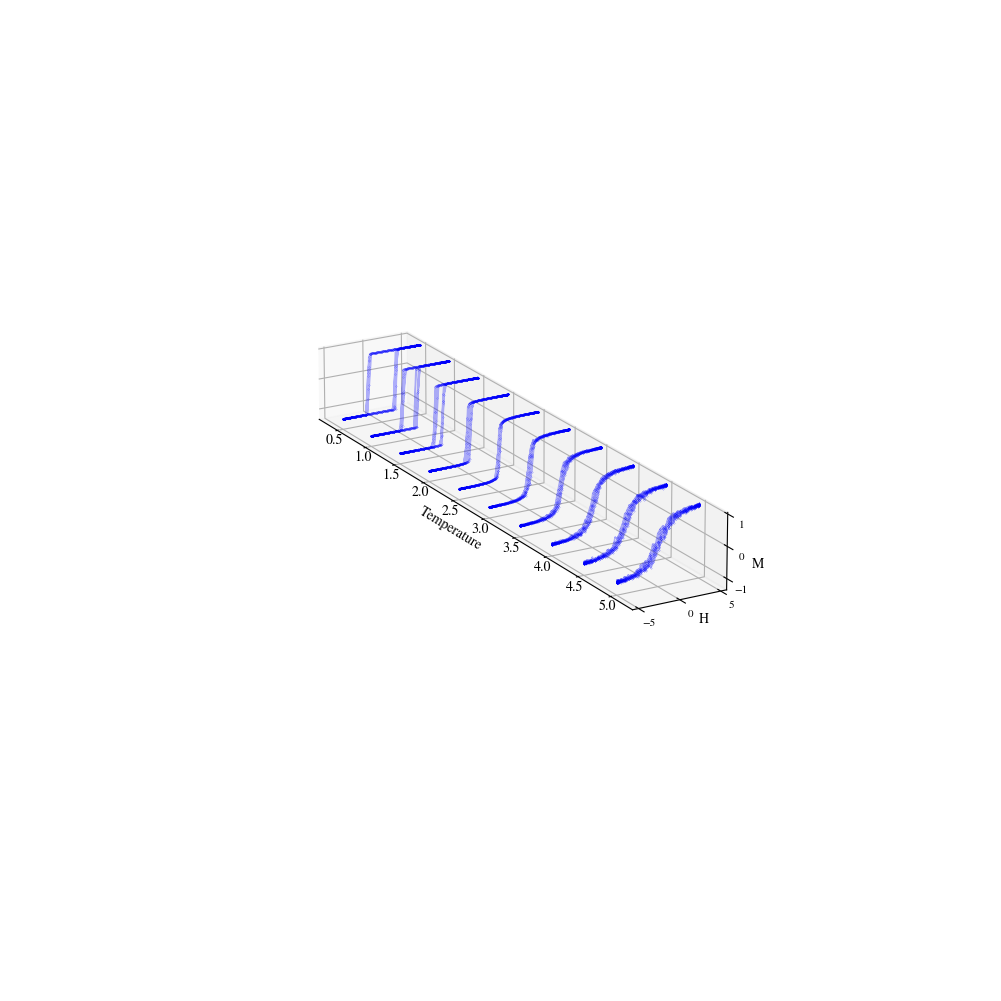

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(13,13), dpi=100)
ax = fig.add_subplot(111, projection='3d')

cmap = cm.get_cmap("jet")

xticks = []
for T, STEPS, Ms, Hs in tqdm(results_ma[::2]):
    plt.plot(np.ones_like(Hs)*T, Hs, Ms, lw=1, alpha=0.3, c="b")
    plt.plot(np.ones_like(Hs)*T, Hs, Ms, marker=".", lw=0,ms=0.2, c="b")

    xticks.append(T)

ax.set_xticks(xticks)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.set_yticks([-5,0,5])
ax.set_zticks([-1,0,1])
    
# ax.set_xticks([-1, 0,1] )
ax.set_xlabel('Temperature', labelpad=50)
ax.set_ylabel('H')
ax.set_zlabel('M')

ax.set_zlim3d(-1.3, 1)

x_scale=6
y_scale=1
z_scale=1

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0
def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj


ax.view_init(elev=20, azim=-30)
plt.savefig("figs/hysteresis.pdf")
plt.show()

In [11]:
del results_ma

# Suseptibility
$$\chi=\frac{1}{N T}\left[\left\langle M^{2}\right\rangle-\langle|M|\rangle^{2}\right]$$

In [40]:
with open("dumps/susceptibility-N32-4e7-v2.pkl", "rb") as f:
    results = pickle.load(f)
with open("dumps/chi-from-Hysteresis.pkl", "rb") as f:
    Ts1, Chis1 = pickle.load(f)

In [16]:
df = pd.DataFrame(results, columns=find_sigma_em.column_names)
df["M^2"] = df.std_M**2 + df.mean_M**2
df["xi1"] = (df["M^2"]-df["mean_abs_M"]**2)/df.N**2/df.temp
df["xi"] = (df["M^2"]-df["mean_M"]**2)/df.N**2/df.temp

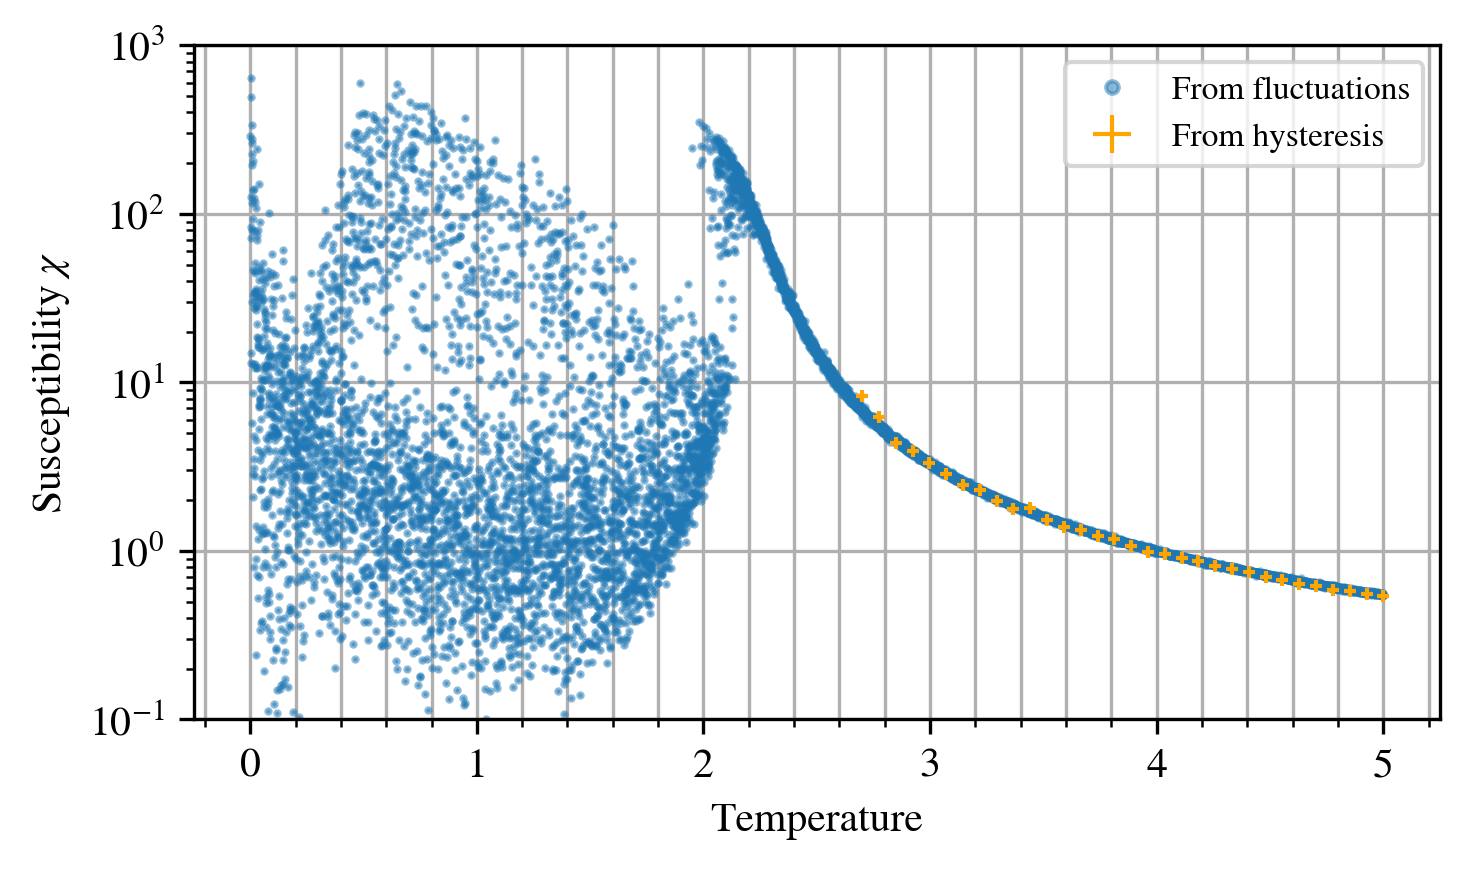

In [68]:
plt.figure(figsize=(5,3), dpi=300)
plt.gca().set_yscale("log")
plt.minorticks_on()
plt.grid(which="both", axis="x")
plt.grid(which="major", axis="y")

plt.plot(df.temp, df.xi, alpha=0.5, marker=".", ms=2,lw=0, rasterized=True, label="From fluctuations")

plt.ylim(0.1, 1000)
# plt.plot(Ts1, Chis1, "o", ms=5, c="None", mec="orange", markeredgewidth=1)
plt.plot(Ts1, Chis1, "+", ms=3, c="orange", markeredgewidth=1, label="From hysteresis")

plt.ylabel('Susceptibility $\\chi$')
plt.xlabel('Temperature')
plt.legend( markerscale=3, fontsize=8)


plt.tight_layout()
plt.savefig("figs/susceptibility.pdf")
plt.show()